In [1]:
import math
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt

#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)

from scipy.integrate import quad, trapz, cumtrapz

import scipy.stats
import scipy.optimize
from scipy.signal import find_peaks, peak_widths

from matplotlib import gridspec

%pylab inline

from lmfit import minimize, Parameters, Model, fit_report

S_n = 7.246 #энергия отрыва нейтрона
S_2n = 17.02

total_GT = 55.54

Populating the interactive namespace from numpy and matplotlib


/home/almaz/miniconda3/envs/science/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trapz']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
from matplotlib import rc
rc("ps", fonttype=42)

In [3]:
def gauss(x, mu, sigma, k):
    return k*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

def line(x, a, b):
    return a*x+b

def breit_vigner2_1(x, M, w, alpha):
    G = alpha * (w ** 2)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов
def breit_vigner2_2(x, M, w, alpha, beta):
    G = alpha*(w**2) + beta*(w**3)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов
def breit_vigner2_3(x, M, w, alpha, beta):
    G = alpha*(w**2) - beta*(w**3)
    #G = alpha * (w ** 2)
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов



def breit_vigner3(x, M, w,  G1):
    G = G1
    y = M * (G**1) * (1-np.exp(-(x/G)**2) ) / ((x - w)**2 + (G**2)/1)
    return np.round(y, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def breit_vigner4(x, M, w,  G1):
    a = M/(2*np.pi*G1)
    b = 1 + np.square(2*(x-w)/G1)
    return np.round(a/b, decimals=5) #округляем чтобы убрать неустойчивость расчета изза хвостов

def QFC_back4(x, E_qf, N_0, Q_EC, S_p, E_projectile):
    W = 22
    T = 100
    E_t_gs = E_projectile - Q_EC
    E_0 = E_t_gs - S_p
    E = E_t_gs - x
    
    values = N_0 * ( 1 - np.exp((E-E_0)/T) )/( 1 + ((E-E_qf)/W)**2)
    values_more0 = values[ np.where(values>0) ]
    beginning = np.zeros((len(x)-len(values_more0)))
    return np.concatenate((beginning, values_more0))

In [4]:
data_to_fit_x = np.linspace(0,25, 4000)

In [5]:
bgt_full = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_full.csv', 
                      sep=';', decimal=',', names=['x', 'y'])
bgt_0_5 = pd.read_csv('../B(GT) peaks processing/recognition/Xe127/1999_bgt_0_5l.csv', 
                      sep=';', decimal=',', names=['x', 'y'])

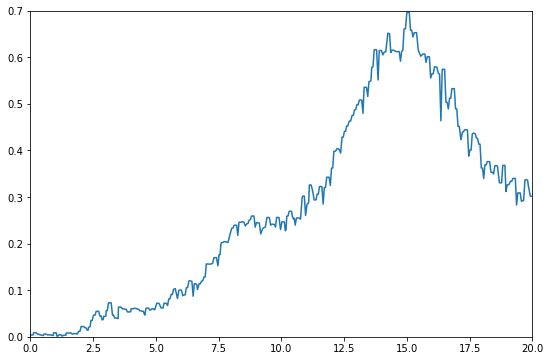

In [6]:
bgt = bgt_0_5.append(bgt_full[bgt_full['x']>5])

plt.figure(figsize=(9,6))
plt.plot(bgt['x'].values, bgt['y'].values)
plt.xlim(0,20)
plt.ylim(0,0.7)
plt.show()

In [7]:
trapz(bgt['y'].values, bgt['x'].values)

5.46327747225692

(0.0, 7.0)

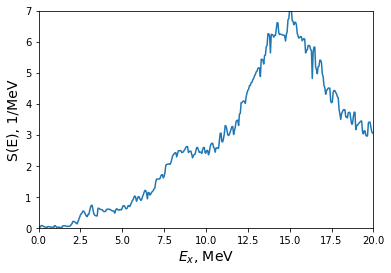

In [8]:
y_bgt = bgt['y'].values / trapz(bgt['y'].values, bgt['x'].values) \
* total_GT
#y_bgt_border = border_func(bgt['x'].values, y_bgt, S_n)

x_values = np.linspace(0,20, 401)
y_bgt_new = np.interp(x_values, bgt['x'].values, y_bgt)

plt.plot(x_values, y_bgt_new, )
plt.xlabel('$E_{x}$, MeV', fontsize=14)
plt.ylabel('S(E), 1/MeV', fontsize=14)
plt.xlim(0,20)
plt.ylim(0,7)

In [9]:
decomp_BW = Model(breit_vigner3,prefix='pigmy1_') \
+Model(breit_vigner3, prefix='pigmy2_') \
+Model(breit_vigner3, prefix='GTR_') \

decomp_BW.set_param_hint('pigmy1_w', value=9, min=5, max=11)
decomp_BW.set_param_hint('pigmy1_G1', value=0.1, min=0.1, max=1.5)
decomp_BW.set_param_hint('pigmy1_M', value=5, min=0.1, max=10)

decomp_BW.set_param_hint('pigmy2_w', value=4, min=2, max=5)
decomp_BW.set_param_hint('pigmy2_G1', value=0.1, min=0.1, max=1.5)
decomp_BW.set_param_hint('pigmy2_M', value=1, min=0.1, max=2)

decomp_BW.set_param_hint('GTR_w', value=14.8, vary=False)
decomp_BW.set_param_hint('GTR_G1', value=2, min=2, max=5)
decomp_BW.set_param_hint('GTR_M', value=5, min=0.1, max= 30)

pars_BW = decomp_BW.make_params()

decomp_BW_result = decomp_BW.fit(y_bgt_new, pars_BW, x=x_values, 
                                 method='differential_evolution')

print(decomp_BW_result.fit_report())

[[Model]]
    ((Model(breit_vigner3, prefix='pigmy1_') + Model(breit_vigner3, prefix='pigmy2_')) + Model(breit_vigner3, prefix='GTR_'))
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 4488
    # data points      = 401
    # variables        = 8
    chi-square         = 31.9377936
    reduced chi-square = 0.08126665
    Akaike info crit   = -998.598718
    Bayesian info crit = -966.647026
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    pigmy1_M:   0.54087260 (init = 5)
    pigmy1_w:   8.26765720 (init = 9)
    pigmy1_G1:  0.62326303 (init = 0.1)
    pigmy2_M:   0.14741935 (init = 1)
    pigmy2_w:   2.98360454 (init = 4)
    pigmy2_G1:  0.57469273 (init = 0.1)
    GTR_M:      24.6563503 (init = 5)
   

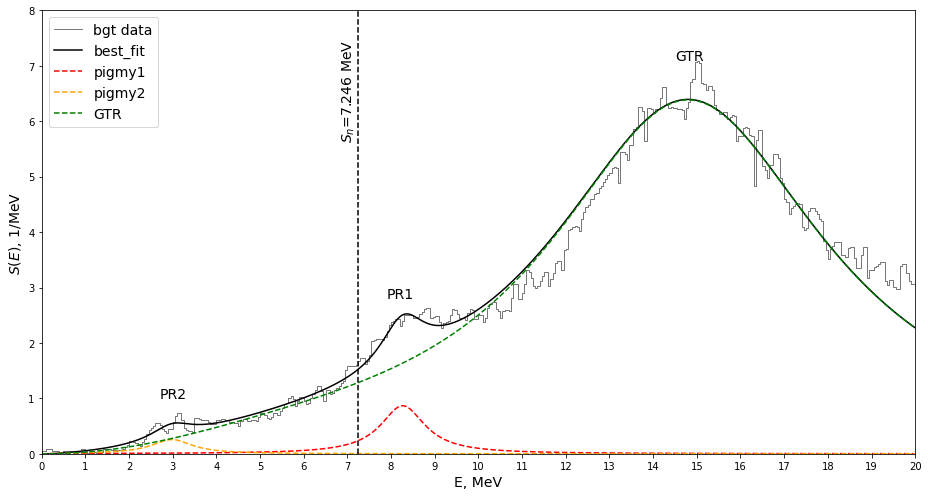

In [10]:
decomp_BW_comps = decomp_BW_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, decomp_BW_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, decomp_BW_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, decomp_BW_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, decomp_BW_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.4, 5.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 2.8, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT_2.png', format='png', dpi=500)
#plt.show()

In [11]:
bgt_gauss = Model(gauss,prefix='pigmy1_') \
+Model(gauss, prefix='pigmy2_') \
+Model(gauss, prefix='GTR_') \

bgt_gauss.set_param_hint('pigmy1_mu', value=9, min=5, max=11)
bgt_gauss.set_param_hint('pigmy1_sigma', value=0.1, min=0.1, max=2)
bgt_gauss.set_param_hint('pigmy1_k', value=5, min=0.1, max=10)

bgt_gauss.set_param_hint('pigmy2_mu', value=4, min=0.1, max=6)
bgt_gauss.set_param_hint('pigmy2_sigma', value=0.1, min=0.1, max=1.0)
bgt_gauss.set_param_hint('pigmy2_k', value=1, min=0.1, max=2)

bgt_gauss.set_param_hint('GTR_mu', value=15.05, vary=False)
bgt_gauss.set_param_hint('GTR_sigma', value=2, min=2, max=2.5)
bgt_gauss.set_param_hint('GTR_k', value=5, min=0.1, max=6.5)

pars = bgt_gauss.make_params()

bgt_gauss_result = bgt_gauss.fit(y_bgt_new, pars, x=x_values, 
                                 method='differential_evolution')

print(bgt_gauss_result.fit_report())

[[Model]]
    ((Model(gauss, prefix='pigmy1_') + Model(gauss, prefix='pigmy2_')) + Model(gauss, prefix='GTR_'))
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 4728
    # data points      = 401
    # variables        = 8
    chi-square         = 114.577747
    reduced chi-square = 0.29154643
    Akaike info crit   = -486.335836
    Bayesian info crit = -454.384144
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    pigmy1_mu:     8.71736982 (init = 9)
    pigmy1_sigma:  2.00000000 (init = 0.1)
    pigmy1_k:      2.16564121 (init = 5)
    pigmy2_mu:     3.59374276 (init = 4)
    pigmy2_sigma:  1.00000000 (init = 0.1)
    pigmy2_k:      0.54117296 (init = 1)
    GTR_mu:        15.05 (fixed)
    GTR_sigma:

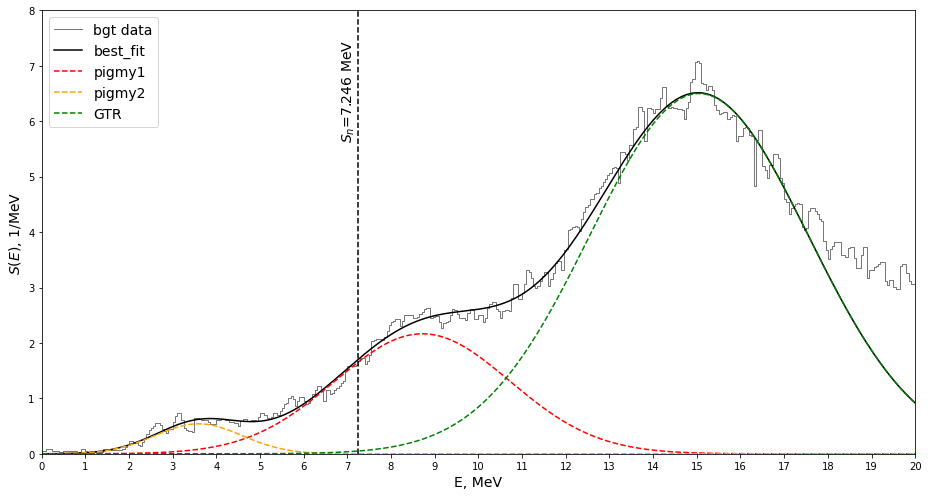

In [12]:
bgt_gauss_comps = bgt_gauss_result.eval_components()

plt.figure(figsize=(13,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
plt.plot(x_values, bgt_gauss_result.best_fit, 'k', ls='-', label='best_fit')
plt.plot(x_values, bgt_gauss_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
plt.plot(x_values, bgt_gauss_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
plt.plot(x_values, bgt_gauss_comps['GTR_'], 'g--', label='GTR')
plt.legend(fontsize=14, loc='upper left')

plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.4, 5.7, '$S_{n}$=7.246 MeV', rotation=90, fontsize=14)
#plt.axvline(S_2n, c='black', ls='--',)
#plt.text(S_2n-0.4, 7.7, '$S_{2n}$=17.02 MeV', rotation=90, fontsize=14)


#plt.text(14.5, 7.1, 'GTR',  fontsize=14)
#plt.text(2.7, 1.0, 'PR2',  fontsize=14)
#plt.text(7.9, 2.8, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
plt.tight_layout()

In [13]:
output = pd.DataFrame(data={'Ex, MeV':x_values,
                            "bgt":y_bgt_new,
                            'best_fit':bgt_gauss_result.best_fit,
                            'gtr':bgt_gauss_comps['GTR_'],
                            'pr1':bgt_gauss_comps['pigmy1_'],
                            'pr2':bgt_gauss_comps['pigmy2_'],
                            })
output.head()

,"Ex, MeV",bgt,best_fit,gtr,pr1,pr2
0,0.00,0.014032,0.001011,8.778301e-08,0.000162,0.000849
1,0.05,0.041647,0.001196,9.899487e-08,0.000181,0.001015
2,0.10,0.041647,0.001412,1.115941e-07,0.000202,0.001210
3,0.15,0.089973,0.001664,1.257465e-07,0.000224,0.001439
4,0.20,0.089973,0.001957,1.416371e-07,0.000250,0.001707


In [14]:
#output.to_excel('127Xe_decomp_decomp_gauss.xls', index=False)

## Матричные элементы от ЮС

In [15]:
En = np.array([0.2, 0.54, 1.58, 1.97, 2.76, 3.08, 3.45, 6.0, 8.34, 14.8, 20.59, 20.94, \
               21.09, 21.22, 29.70])

Mn = 2*np.array([0.0025, 0.0025, 0.01, 0.01, 0.02, 0.10, 0.01, 0.2, 1.2, 30.8, 0.5, 0.8, \
               0.5, 1.03, 6.3])

np.sum(Mn)

82.97

In [16]:
Mn2 = 2*np.array([0.0005,0.0025,0.01,0.01,0.02,0.15,0.01,0.157,0.0,1.16,0.0,0,0.0,0.0,
                29.15,0.7,0.6,0.2,0.6,0.4,1.03,1.4,0.82,0.4,3.49])
En2 = np.array([0.2,1.54,1.58,1.97,2.76,3.08,3.45,6.0,6.64,8.32,9.92,12.75,
               13.7,14.05,14.4,15.78,18.71,18.59,18.94,19.09,19.22,19.78,20.23,21.47,24.70])


In [17]:
Ex = np.arange(0,40,0.01)
w = En[0:15]
M_square = Mn[0:15]
alpha = 0.0165


norm_factors = []
for w_i,M_i in zip(w, M_square):
    y_values = breit_vigner3(Ex, 1, w_i, alpha*w_i**2)
    norm_factors.append(trapz(y_values, Ex))

plots = np.zeros((w.shape[0], Ex.shape[0]))
for idx, w_i, M_i, norm_i in zip(range(w.shape[0]), w, M_square, norm_factors):
    amplitude = M_i / norm_i
    y_values = breit_vigner3(Ex, amplitude, w_i, alpha*w_i**2)
    plots[idx] = y_values
    
summ = np.sum(plots[:11], axis=0)

In [18]:
plots.shape

(15, 4000)

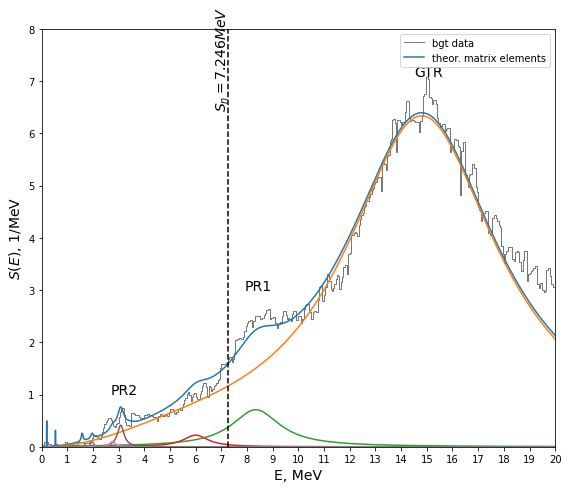

In [19]:
#total_mod_comps = total_mod_result.eval_components()

plt.figure(figsize=(8,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, 'dimgrey', linewidth=0.9, label='bgt data')
#plt.plot(x_values, total_mod_result.best_fit, 'k', ls='-', label='best_fit')
#plt.plot(x_values, total_mod_comps['pigmy1_'], 'red', ls='--', label='pigmy1',)
#plt.plot(x_values, total_mod_comps['pigmy2_'], 'orange', ls='--', label='pigmy2')
#plt.plot(x_values, total_mod_comps['GTR_'], 'g--', label='GTR')
plt.plot(Ex, summ, label='theor. matrix elements')
plt.plot(Ex, plots[9])
plt.plot(Ex, plots[8])
plt.plot(Ex, plots[7])
plt.plot(Ex, plots[6])
plt.plot(Ex, plots[5])
plt.plot(Ex, plots[4])
plt.plot(Ex, plots[3])
plt.legend()
plt.axvline(S_n, c='black', ls='--',)
plt.text(S_n-0.5, 6.5, '$S_{n}=7.246 MeV$', rotation=90, fontsize=14)

plt.text(14.5, 7.1, 'GTR',  fontsize=14)
plt.text(2.7, 1.0, 'PR2',  fontsize=14)
plt.text(7.9, 3, 'PR1',  fontsize=14)

plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
plt.ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
plt.ylim(0,8)
plt.xlim(0,20)
plt.xticks(np.arange(0,21,1))
#plt.show()
plt.tight_layout()
#plt.savefig('Xe127_decomposition_BGT.png', format='png', dpi=500)

In [20]:
f, ax = plt.subplots(figsize=(8,7))
#plt.plot(data['x'].values, data['y'].values)
plt.step(x_values, y_bgt_new, c='dimgray', linewidth=0.9, label='bgt data')

color_theory = 'black'
ls_theory = '--'
linewidth_theory = 0.9
plt.plot(Ex, summ, c=color_theory, ls='-', linewidth=linewidth_theory)
plt.plot(Ex, plots[9], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[8], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[7], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[6], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[5], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[4], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[3], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)

decomp_BW_comps = decomp_BW_result.eval_components()
color_BW = 'red'
ls_BW = '-.'
linewidth_BW = 0.9
plt.plot(x_values, decomp_BW_result.best_fit, c=color_BW, ls='-', linewidth=linewidth_BW)
plt.plot(x_values, decomp_BW_comps['pigmy1_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
plt.plot(x_values, decomp_BW_comps['pigmy2_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
plt.plot(x_values, decomp_BW_comps['GTR_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)

color_gauss = 'green'
ls_gauss = '--'
linewidth_gauss = 0.9
#plt.plot(x_values, bgt_gauss_result.best_fit, c=color_gauss, ls='-', linewidth=linewidth_gauss)
#plt.plot(x_values, bgt_gauss_comps['pigmy1_'], c=color_gauss, ls=ls_gauss, linewidth=linewidth_gauss)
#plt.plot(x_values, bgt_gauss_comps['pigmy2_'], c=color_gauss, ls=ls_gauss, linewidth=linewidth_gauss)
#plt.plot(x_values, bgt_gauss_comps['GTR_'], c=color_gauss, ls=ls_gauss, linewidth=linewidth_gauss)

ax.tick_params(direction='in', labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('$S(E)$, 1/MeV', rotation=90, fontsize=14)
ax.yaxis.set_label_coords(-0.1,0,9)
ax.set_xlabel('E, MeV', fontsize=14)
ax.xaxis.set_label_coords(0.97,-0.05)

#ax.arrow(21, 3.0, -0.55, -0.25, head_width=0.1, width=0.02, fc='k', ec='k')
#plt.text(21, 3.0, '2',  fontsize=14)
#ax.arrow(20.7, 3.6, -0.55, -0.25, head_width=0.1, width=0.02,fc='k', ec='k')
#plt.text(20.7, 3.6, '1',  fontsize=14)

plt.text(14.4, 7.2, 'GTR',  fontsize=14)
plt.text(7.99, 2.8, 'PR1',  fontsize=14)
#plt.text(5.5, 1.5, 'PR2',  fontsize=14)
plt.text(2.7, 0.9, 'PR2',  fontsize=14)

#plt.xlabel('E, MeV',fontsize=14)
#plt.ylabel('S(E), 1/MeV')
#plt.ylabel('$S(E)$, 1/MeV', fontsize=14)
plt.ylim(0,8)
plt.xlim(0,18)
plt.xticks(np.arange(0,19,2))
#plt.show()
plt.tight_layout()
#plt.savefig('fig2_v2.png', format='png', dpi=500)

AttributeError: 'int' object has no attribute 'transform'

AttributeError: 'int' object has no attribute 'transform'

<Figure size 576x504 with 1 Axes>

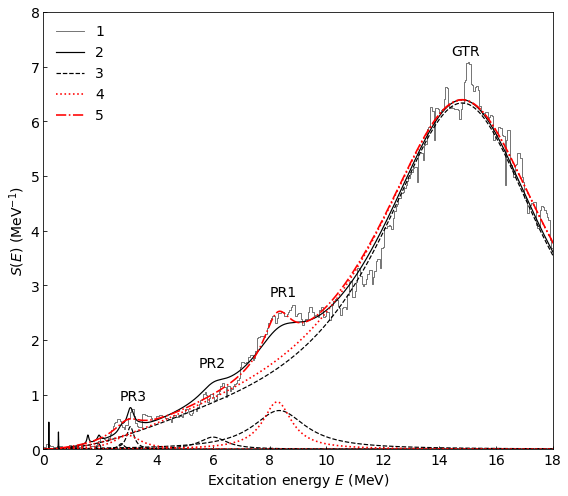

In [21]:
f, ax = plt.subplots(figsize=(8,7))
#plt.plot(data['x'].values, data['y'].values)

#fig = plt.figure(figsize=(8,7))
# set height ratios for sublots
#gs = gridspec.GridSpec(2, 1, height_ratios=[100, 1]) 

ax0 = ax

ax0.step(x_values, y_bgt_new, c='dimgray', linewidth=0.9, label = '1')

color_theory = 'black'
ls_theory = '--'
linewidth_theory = 1.2
ax0.plot(Ex, summ, c=color_theory, ls='-', linewidth=linewidth_theory, label='2')
ax0.plot(Ex, plots[9], c=color_theory, ls=ls_theory, linewidth=linewidth_theory, label='3')
ax0.plot(Ex, plots[8], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
ax0.plot(Ex, plots[7], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
ax0.plot(Ex, plots[6], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
ax0.plot(Ex, plots[5], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
ax0.plot(Ex, plots[4], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
ax0.plot(Ex, plots[3], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)

decomp_BW_comps = decomp_BW_result.eval_components()
color_BW = 'red'
ls_BW = ':'
linewidth_BW = 1.6


ax0.plot(x_values, decomp_BW_comps['pigmy1_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW, label='4')
ax0.plot(x_values, decomp_BW_result.best_fit, c=color_BW, ls='-.', linewidth=linewidth_BW, label='5')
ax0.plot(x_values, decomp_BW_comps['pigmy2_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
ax0.plot(x_values, decomp_BW_comps['GTR_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)

ax0.tick_params(direction='in', labelsize=14)
#ax0.spines['right'].set_visible(False)
#ax0.spines['top'].set_visible(False)
ax0.set_ylabel('$S(E)$ (MeV$^{-1}$)', rotation=90, fontsize=14)
#ax0.yaxis.set_label_coords(-0.1,0,9)
ax0.set_xlabel('Excitation energy $E$ (MeV)', fontsize=14)
#ax.arrow(21, 3.0, -0.55, -0.25, head_width=0.1, width=0.02, fc='k', ec='k')
#plt.text(21, 3.0, '2',  fontsize=14)
#ax.arrow(20.7, 3.6, -0.55, -0.25, head_width=0.1, width=0.02,fc='k', ec='k')
#plt.text(20.7, 3.6, '1',  fontsize=14)

ax0.text(14.4, 7.2, 'GTR',  fontsize=14)
ax0.text(7.99, 2.8, 'PR1',  fontsize=14)
plt.text(5.5, 1.5, 'PR2',  fontsize=14)
ax0.text(2.7, 0.9, 'PR3',  fontsize=14)

ax0.legend(loc='upper left', frameon=False, fontsize=14)

ax0.set_ylim(0,8)
ax0.set_xlim(0,18)
ax0.set_xticks(np.arange(0,19,2))
plt.tight_layout()
#plt.savefig('fig2_v3.jpg', format='jpg', bbox_inches='tight', transparent=False, dpi=300)
plt.show()

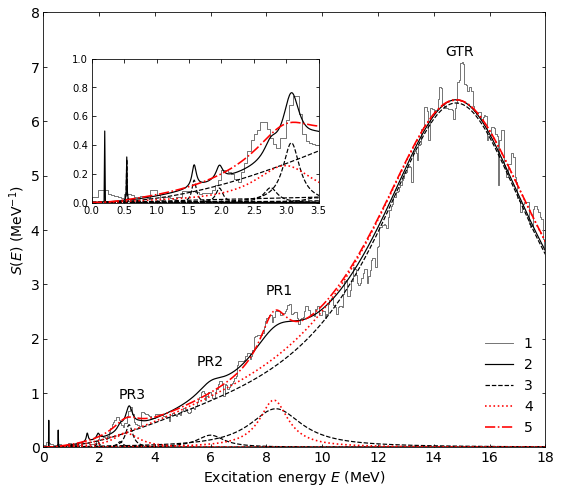

In [22]:

#plt.plot(data['x'].values, data['y'].values)

fig = plt.figure(figsize=(9,8))
# set height ratios for sublots
#gs = gridspec.GridSpec(2, 1, height_ratios=[100, 1]) 

#plt.rcParams['axes.unicode_minus'] = False

plt.step(x_values, y_bgt_new, c='dimgray', linewidth=0.9, label = '1')

color_theory = 'black'
ls_theory = '--'
linewidth_theory = 1.2
plt.plot(Ex, summ, c=color_theory, ls='-', linewidth=linewidth_theory, label='2')
plt.plot(Ex, plots[9], c=color_theory, ls=ls_theory, linewidth=linewidth_theory, label='3')
plt.plot(Ex, plots[8], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[7], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[6], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[5], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[4], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[3], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)

decomp_BW_comps = decomp_BW_result.eval_components()
color_BW = 'red'
ls_BW = ':'
linewidth_BW = 1.6


plt.plot(x_values, decomp_BW_comps['pigmy1_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW, label='4')
plt.plot(x_values, decomp_BW_result.best_fit, c=color_BW, ls='-.', linewidth=linewidth_BW, label='5')
plt.plot(x_values, decomp_BW_comps['pigmy2_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
plt.plot(x_values, decomp_BW_comps['GTR_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)

plt.tick_params(direction='in', labelsize=14, right=True, top=True,)

#ax0.spines['right'].set_visible(False)
#ax0.spines['top'].set_visible(False)
plt.ylabel('$S(E)$ $(\mathrm{MeV}^{-1}$)', rotation=90, fontsize=14)
#ax0.yaxis.set_label_coords(-0.1,0,9)
plt.xlabel('Excitation energy $E$ (MeV)', fontsize=14)
#ax.arrow(21, 3.0, -0.55, -0.25, head_width=0.1, width=0.02, fc='k', ec='k')
#plt.text(21, 3.0, '2',  fontsize=14)
#ax.arrow(20.7, 3.6, -0.55, -0.25, head_width=0.1, width=0.02,fc='k', ec='k')
#plt.text(20.7, 3.6, '1',  fontsize=14)

plt.text(14.4, 7.2, 'GTR',  fontsize=14)
plt.text(7.99, 2.8, 'PR1',  fontsize=14)
plt.text(5.5, 1.5, 'PR2',  fontsize=14)
plt.text(2.7, 0.9, 'PR3',  fontsize=14)

plt.legend(loc='lower right', frameon=False, fontsize=14)

plt.ylim(0,8)
plt.xlim(0,18)
plt.xticks(np.arange(0,19,2))



a = plt.axes([0.2, 0.55, .35, .25],)
plt.step(x_values, y_bgt_new, c='dimgray', linewidth=0.9, label = '1')

plt.plot(Ex, summ, c=color_theory, ls='-', linewidth=linewidth_theory, label='2')
plt.plot(Ex, plots[9], c=color_theory, ls=ls_theory, linewidth=linewidth_theory, label='3')
plt.plot(Ex, plots[8], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[7], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[6], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[5], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[4], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[3], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[2], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)
plt.plot(Ex, plots[1], c=color_theory, ls=ls_theory, linewidth=linewidth_theory)


#plt.plot(x_values, decomp_BW_comps['pigmy1_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW, label='4')
plt.plot(x_values, decomp_BW_result.best_fit, c=color_BW, ls='-.', linewidth=linewidth_BW, label='5')
plt.plot(x_values, decomp_BW_comps['pigmy2_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
#plt.plot(x_values, decomp_BW_comps['GTR_'], c=color_BW, ls=ls_BW, linewidth=linewidth_BW)
plt.ylim(0,1)
plt.xlim(0,3.5)
plt.xticks(np.arange(0,4,0.5))
plt.tick_params(direction='in', labelsize=10, right=True, top=True,)



#plt.rcParams['font.sans-serif'] = "CMU Sans Serif"
#plt.tight_layout()
#plt.savefig('fig2_v3.jpg', format='jpg', bbox_inches='tight', transparent=False, dpi=300)
#при сохранении в eps исчезает знак минус
plt.savefig('fig2_v4.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
output = pd.DataFrame(data={'Ex, MeV':x_values,
                            "bgt":y_bgt_new,
                            "best_fit":total_mod_result.best_fit,
                            'pr1':total_mod_comps['pigmy1_'],
                            "pr2":total_mod_comps['pigmy2_'],
                            "gtr":total_mod_comps['GTR_']})
output.head()

In [ ]:
#output.to_excel('127Xe_bgt_decomp.xls', index=False)

In [ ]:
#y_bgt_new[:-1].reshape((20,20))

In [ ]:
#y_bgt_new[:-1].reshape((20,20))[:,-1]

In [21]:
np.cumsum(y_bgt_new[1:]).shape

(400,)

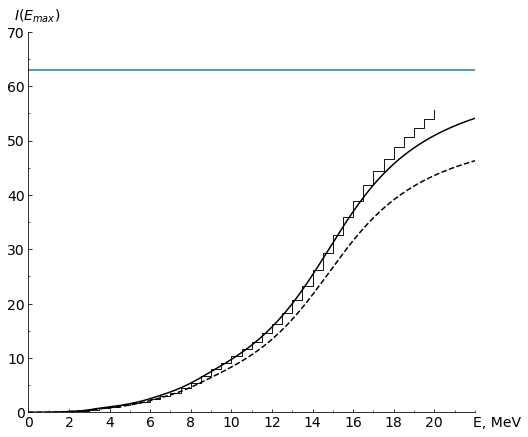

In [22]:
f, ax = plt.subplots(figsize=(8,7))
plt.step(x_values[1:].reshape((40,10))[:,-1], cumtrapz(y_bgt_new, x_values).reshape((40,10))[:,-1], c='black', 
         linewidth=0.9, where='post')
plt.plot(Ex[1:], cumtrapz(0.935*summ, Ex), c='black')
plt.plot(Ex[1:], cumtrapz(0.8*summ, Ex), c='black', ls='--')
ax.hlines(63, 0,22)

ax.tick_params(direction='in', which='both',labelsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('$I(E_{max})$', rotation=0, fontsize=14)
ax.yaxis.set_label_coords(0.02,1.02)
ax.set_xlabel('E, MeV', fontsize=14)
ax.xaxis.set_label_coords(1.05,-0.008)

ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

plt.xticks(np.arange(0,21,2))
plt.xlim(0,22)
plt.ylim(0,70)

#plt.grid(True)
plt.savefig('Xe127_cumsum.svg', format='svg',)

In [185]:
Ex[1], Ex[0]

(0.01, 0.0)